# Workflow Interface 401: Synthetic non-IID Dataset with FedProx Optimizer
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_401_FedProx_with_Synthetic_nonIID.ipynb)

In this OpenFL workflow interface tutorial, we shall learn how to implement FedProx and compare its performance with FedAvg algorithm using a Synthetic non-IID dataset. Reference: [Federated Optimization in Heterogeneous Networks](https://arxiv.org/pdf/1812.06127.pdf).

# Getting Started

First we start by installing the necessary dependencies for the workflow interface

In [ ]:
!pip install git+https://github.com/securefederatedai/openfl.git
!pip install -r workflow_interface_requirements.txt
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install seaborn

# Uncomment following lines if running in Google Colab
# import os
# os.environ["USERNAME"] = "colab"

Next we import necessary libraries, and define Synthetic non-iid dataset as described in [Federated Optimization in Heterogeneous Networks](https://arxiv.org/pdf/1812.06127.pdf).

In [ ]:
import torch as pt
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import random
import collections
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [ ]:
RANDOM_SEED = 10
batch_size = 10

# Sets seed to reproduce the results
def set_seed(seed):
    pt.manual_seed(seed)
    pt.cuda.manual_seed_all(seed)
    pt.use_deterministic_algorithms(True)
    pt.backends.cudnn.deterministic = True
    pt.backends.cudnn.benchmark = False
    pt.backends.cudnn.enabled = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(RANDOM_SEED)


def one_hot(labels, classes):
    return np.eye(classes)[labels]


def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum(np.exp(x))
    return ex / sum_ex


def generate_synthetic(alpha, beta, iid, num_collaborators, num_classes):
    dimension = 60
    NUM_CLASS = num_classes
    NUM_USER = num_collaborators

    samples_per_user = np.random.lognormal(4, 2, (NUM_USER)).astype(int) + 50
    num_samples = np.sum(samples_per_user)

    X_split = [[] for _ in range(NUM_USER)]
    y_split = [[] for _ in range(NUM_USER)]

    #### define some eprior ####
    mean_W = np.random.normal(0, alpha, NUM_USER)
    mean_b = mean_W
    B = np.random.normal(0, beta, NUM_USER)
    mean_x = np.zeros((NUM_USER, dimension))

    diagonal = np.zeros(dimension)
    for j in range(dimension):
        diagonal[j] = np.power((j + 1), -1.2)
    cov_x = np.diag(diagonal)

    for i in range(NUM_USER):
        if iid == 1:
            mean_x[i] = np.ones(dimension) * B[i]  # all zeros
        else:
            mean_x[i] = np.random.normal(B[i], 1, dimension)

    if iid == 1:
        W_global = np.random.normal(0, 1, (dimension, NUM_CLASS))
        b_global = np.random.normal(0, 1, NUM_CLASS)

    for i in range(NUM_USER):

        W = np.random.normal(mean_W[i], 1, (dimension, NUM_CLASS))
        b = np.random.normal(mean_b[i], 1, NUM_CLASS)

        if iid == 1:
            W = W_global
            b = b_global

        xx = np.random.multivariate_normal(
            mean_x[i], cov_x, samples_per_user[i])
        yy = np.zeros(samples_per_user[i])

        for j in range(samples_per_user[i]):
            tmp = np.dot(xx[j], W) + b
            yy[j] = np.argmax(softmax(tmp))

        X_split[i] = xx.tolist()
        y_split[i] = yy.tolist()

    return X_split, y_split


class SyntheticFederatedDataset:
    def __init__(self, num_collaborators, batch_size=1, num_classes=10, **kwargs):
        self.batch_size = batch_size
        X, y = generate_synthetic(0.0, 0.0, 0, num_collaborators, num_classes)
        X = [np.array([np.array(sample).astype(np.float32)
                      for sample in col]) for col in X]
        y = [np.array([np.array(one_hot(int(sample), num_classes))
                      for sample in col]) for col in y]
        self.X_train_all = np.array([col[:int(0.9 * len(col))] for col in X], dtype=np.ndarray)
        self.X_valid_all = np.array([col[int(0.9 * len(col)):] for col in X], dtype=np.ndarray)
        self.y_train_all = np.array([col[:int(0.9 * len(col))] for col in y], dtype=np.ndarray)
        self.y_valid_all = np.array([col[int(0.9 * len(col)):] for col in y], dtype=np.ndarray)

    def split(self, index):
        return {
            "train_loader":
                data.DataLoader(
                    data.TensorDataset(
                        pt.from_numpy(self.X_train_all[index]),
                        pt.from_numpy(self.y_train_all[index])
                    ), 
                    batch_size=batch_size, shuffle=True
                ),
            "test_loader":
                data.DataLoader(
                    data.TensorDataset(
                        pt.from_numpy(self.X_valid_all[index]),
                        pt.from_numpy(self.y_valid_all[index])
                    ), 
                    batch_size=batch_size, shuffle=True
                )
        }

Now that we have defined dataset class. Let define model, optimizer, and some helper functions like we would for any other deep learning experiment.

In [ ]:
from openfl.interface.aggregation_functions.weighted_average import weighted_average as wa


class Net(nn.Module):
    """
    Model to train the dataset

    Args:
        None
    
    Returns:
        model: class Net object
    """
    def __init__(self):
        # Set RANDOM_STATE to reproduce same model
        pt.set_rng_state(pt.manual_seed(RANDOM_SEED).get_state())
        super(Net, self).__init__()
        self.linear1 = nn.Linear(60, 100)
        self.linear2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x


def cross_entropy(output, target):
    """
    cross-entropy metric

    Args:
        output: model ouput,
        target: target label

    Returns:
        crossentropy_loss: float
    """
    return F.cross_entropy(output, pt.max(target, 1)[1])


def compute_loss_and_acc(network, dataloader):
    """
    Model test method

    Args:
        network: class Net object (model)
        dataloader: torch.utils.data.DataLoader

    Returns:
        (accuracy,
        loss,
        correct,
        dataloader_size)
    """
    network.eval()
    test_loss = 0
    correct = 0
    with pt.no_grad():
        for data, target in dataloader:
            output = network(data)
            test_loss += cross_entropy(output, target).item()
            tar = target.argmax(dim=1, keepdim=True)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(tar).sum().cpu().numpy()
    dataloader_size = len(dataloader.dataset)
    test_loss /= dataloader_size
    accuracy = float(correct / dataloader_size)
    return accuracy, test_loss, correct


def weighted_average(tensors, weights):
    """
    Take weighted average of models / optimizers / loss / accuracy
    Incase of taking weighted average of optimizer do the following steps:
    1.  Call "_get_optimizer_state" (openfl.federated.task.runner_pt._get_optimizer_state)
        pass optimizer to it, to take optimizer state dictionary.
    2.  Pass optimizer state dictionaries list to here.
    3.  To set the weighted average optimizer state dictionary back to optimizer,
        call "_set_optimizer_state" (openfl.federated.task.runner_pt._set_optimizer_state)
        and pass optimizer, device, and optimizer dictionary received in step 2.

    Args:
        tensors: Models state_dict list or optimizers state_dict list or loss list or accuracy list
        weights: Weight for each element in the list

    Returns:
        dict: Incase model list / optimizer list OR
        float: Incase of loss list or accuracy list
    """
    # Check the type of first element of tensors list
    if type(tensors[0]) in (dict, collections.OrderedDict):
        optimizer = False
        # If __opt_state_needed found then optimizer state dictionary is passed
        if "__opt_state_needed" in tensors[0]:
            optimizer = True
            # Remove __opt_state_needed from all state dictionary in list
            [tensor.pop("__opt_state_needed") for tensor in tensors]
        tmp_list = []
        # Take keys in order to rebuild the state dictionary taking keys back up
        input_state_dict_keys = tensors[0].keys()
        for tensor in tensors:
            # Append values of each state dictionary in list
            # If type(value) is Tensor then it needs to be detached
            tmp_list.append(np.array([value.detach() if type(value) is pt.Tensor else value for value in tensor.values()], dtype=object))
        # Take weighted average of list of arrays
        # new_params passed is weighted average of each array in tmp_list
        new_params = wa(tmp_list, weights)
        new_state = {}
        # Take weighted average parameters and building a dictionary
        [new_state.update({k:new_params[i]}) if optimizer else new_state.update({k:pt.from_numpy(new_params[i].numpy())}) \
            for i, k in enumerate(input_state_dict_keys)]
        return new_state
    else:
        return wa(tensors, weights)

Let us now define the Workflow for our experiment. Here we use the methodology as provided in [quickstart](https://github.com/securefederatedai/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_101_MNIST.ipynb), and define the workflow consisting of following steps:
-	`start`: Start of the flow 
-	`compute_loss_and_accuracy`: Compute Train Loss and Test Accuracy on aggregated model. Performed *foreach collaborator* in Federation
-	`gather_results_and_take_weighted_average`: Collect train loss, and test accuracy metrics for each collaborator and take weighted average to compute the *Aggregated* Train Loss and Test Accuracy. Performed on Aggregator
-	`select_collaborators`: Randomly select *n_selected_collaborators* from the entire set of collaborators in Federation. Performed on Aggregator
-	‘train_selected_collaborators` - Train selected collaborators on its individual datasets for *local_epoch* number of times. Performed on *n_selected_collaborators*
-	`join`: Take weighted average of the model. Performed on Aggregator
-	`end`: End of one round of flow. Flow can be run for *n_epochs* to obtain the desired results

We also import the FedProxOptimizer from openfl.utilities.optimizer

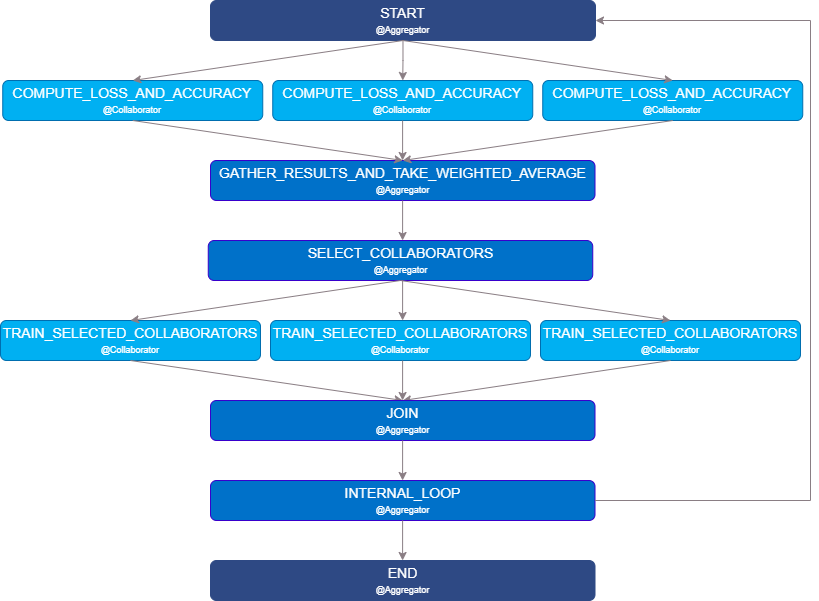

In [ ]:
from openfl.experimental.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.runtime import LocalRuntime
from openfl.experimental.placement import aggregator, collaborator
from openfl.utilities.optimizers.torch import FedProxOptimizer

In [ ]:
class FedProxFlow(FLSpec):

    def __init__(self, model=None, optimizer=None, n_selected_collaborators=10, n_rounds=10, **kwargs):
        super(FedProxFlow, self).__init__(**kwargs)
        self.round_number = 1
        self.n_selected_collaborators = n_selected_collaborators
        self.n_rounds = n_rounds
        self.loss_and_acc = {"Train Loss": [], "Test Accuracy": []}
        if model is not None:
            self.model = model
            self.optimizer = optimizer
        else:
            self.model = Net()
            self.optimizer = FedProxOptimizer(
                self.model.parameters(), lr=learning_rate, mu=mu, weight_decay=weight_decay)

    @aggregator
    def start(self):
        """
        Start of the flow. Call compute_loss_and_accuracy step for each collaborator
        """
        print(f'\nStarting round number {self.round_number} .... \n')
        self.collaborators = self.runtime.collaborators
        self.next(self.compute_loss_and_accuracy, foreach='collaborators')

    @collaborator
    def compute_loss_and_accuracy(self):
        """
        Compute training accuracy, training loss, aggregated validation accuracy,
        aggregated validation loss, 
        """
        # Compute Train Loss and Train Acc
        self.training_accuracy, self.training_loss, _, = compute_loss_and_acc(
            self.model, self.train_loader)
        
        # Compute Test Loss and Test Acc
        self.agg_validation_score, self.agg_validation_loss, test_correct = compute_loss_and_acc(
            self.model, self.test_loader)

        self.train_dataset_length = len(self.train_loader.dataset)
        self.test_dataset_length = len(self.test_loader.dataset)

        print(
            "<Collab: {:<5}> | Train Round: {:<5} : Train Loss {:<.6f}, Test Acc: {:<.6f} [{}/{}]".format(
                self.input,
                self.round_number,
                self.training_loss,
                self.agg_validation_score,
                test_correct, 
                self.test_dataset_length
            )
        )

        self.next(self.gather_results_and_take_weighted_average)

    @aggregator
    def gather_results_and_take_weighted_average(self, inputs):
        """
        Gather results of all collaborators computed in previous 
        step.
        Compute train and test weightes, and compute weighted average of 
        aggregated training loss, and aggregated test accuracy
        """
        # Calculate train_weights and test_weights
        train_datasize, test_datasize = [], []
        for input_ in inputs:
            train_datasize.append(input_.train_dataset_length)
            test_datasize.append(input_.test_dataset_length)

        self.train_weights, self.test_weights = [], []
        for input_ in inputs:
            self.train_weights.append(input_.train_dataset_length / sum(train_datasize))
            self.test_weights.append(input_.test_dataset_length / sum(test_datasize))

        aggregated_model_accuracy_list, aggregated_model_loss_list = [], []
        for input_ in inputs:
            aggregated_model_loss_list.append(input_.training_loss)
            aggregated_model_accuracy_list.append(input_.agg_validation_score)

        # Weighted average of training loss
        self.aggregated_model_training_loss = weighted_average(aggregated_model_loss_list, self.train_weights)
        # Weighted average of aggregated model accuracy
        self.aggregated_model_test_accuracy = weighted_average(aggregated_model_accuracy_list, self.test_weights)

        # Store experiment results
        self.loss_and_acc["Train Loss"].append(self.aggregated_model_training_loss)
        self.loss_and_acc["Test Accuracy"].append(self.aggregated_model_test_accuracy)

        print(
            "<Agg> | Train Round: {:<5} : Agg Train Loss {:<.6f}, Agg Test Acc: {:<.6f}".format(
                self.round_number,
                self.aggregated_model_training_loss,
                self.aggregated_model_test_accuracy
            )
        )

        self.next(self.select_collaborators)

    @aggregator
    def select_collaborators(self):
        """
        Randomly select n_selected_collaborators collaborator
        """
        np.random.seed(self.round_number)
        self.selected_collaborator_indices = np.random.choice(range(len(self.collaborators)), \
            self.n_selected_collaborators, replace=False)
        self.selected_collaborators = [self.collaborators[idx] for idx in self.selected_collaborator_indices]

        self.next(self.train_selected_collaborators, foreach="selected_collaborators")

    @collaborator
    def train_selected_collaborators(self):
        """
        Train selected collaborators
        """
        self.model.train(mode=True)

        self.train_dataset_length = len(self.train_loader.dataset)

        # Rebuild the optimizer with global model parameters
        self.optimizer = FedProxOptimizer(
            self.model.parameters(), lr=learning_rate, mu=mu, weight_decay=weight_decay)
        # Set global model parameters as old weights to enable computation of proximal term
        self.optimizer.set_old_weights([p.clone().detach() for p in self.model.parameters()])

        for epoch in range(local_epoch):
            train_loss = []
            correct = 0
            for data, target in self.train_loader:
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = cross_entropy(output, target)
                loss.backward()
                self.optimizer.step()
                pred = output.argmax(dim=1, keepdim=True)
                tar = target.argmax(dim=1, keepdim=True)
                correct += pred.eq(tar).sum().cpu().numpy()
                train_loss.append(loss.item())
            training_accuracy = float(correct / self.train_dataset_length)
            training_loss = np.mean(train_loss)
            print(
                "<Collab: {:<5}> | Train Round: {:<5} | Local Epoch: {:<3}: FedProx Optimization Train Loss {:<.6f}, Train Acc: {:<.6f} [{}/{}]".format(
                    self.input,
                    self.round_number,
                    epoch,
                    training_loss,
                    training_accuracy,
                    correct, 
                    len(self.train_loader.dataset)
                )
            )

        self.next(self.join)
    
    @aggregator
    def join(self, inputs):
        """
        Compute train dataset, and take weighted average of model.
        """
        train_datasize = sum([input_.train_dataset_length for input_ in inputs])

        train_weights, model_state_dict_list = [], [] 
        for input_ in inputs:
            train_weights.append(input_.train_dataset_length / train_datasize)
            model_state_dict_list.append(input_.model.state_dict())

        avg_model_dict = weighted_average(model_state_dict_list, train_weights)
        self.model.load_state_dict(avg_model_dict)

        self.next(self.internal_loop)

    @aggregator
    def internal_loop(self):
        """
        Check if training is finished for `self.n_rounds`
        if finished move to end step. Otherwise, go back to start
        step for next round of training.
        """
        if self.round_number < self.n_rounds:
            self.round_number += 1
            self.next(self.start)
        else:
            self.next(self.end)

    @aggregator
    def end(self):
        """
        This is the 'end' step.
        """
        self.round_number += 1
        print('This is end of the flow')

# Setup Federation

In this step we define entities necessary to run the flow and create a function which returns dataset as private attributes of collaborator. As described in [quickstart](https://github.com/securefederatedai/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_101_MNIST.ipynb) we define entities necessary for the flow.

In [ ]:
num_collaborators = 30

# Setup aggregator
aggregator = Aggregator()

# Setup collaborators with private attributes
collaborator_names = [f"col{i}" for i in range(num_collaborators)]

synthetic_federated_dataset = SyntheticFederatedDataset(
    batch_size=batch_size, num_classes=10, num_collaborators=len(collaborator_names), seed=RANDOM_SEED)

def callable_to_initialize_collaborator_private_attributes(index):
    return synthetic_federated_dataset.split(index)

collaborators = []
for idx, collaborator_name in enumerate(collaborator_names):
    collaborators.append(
        Collaborator(
            name=collaborator_name, num_cpus=0.0, num_gpus=0.0,
            private_attributes_callable=callable_to_initialize_collaborator_private_attributes,
            index=idx
        )
    )

local_runtime = LocalRuntime(
    aggregator=aggregator, collaborators=collaborators, backend="single_process")

We define `loss_and_acc` dictionary to store the test results of our experiment.

In [ ]:
loss_and_acc = {
    "FedProx": {
        "Train Loss": [], "Test Accuracy": []
    },
    "FedAvg": {
        "Train Loss": [], "Test Accuracy": []
    }
}

## Data Distribution

Now that our Federation is setup and actors (Aggregator & Collaborators) are initialized, let us take a moment to analyze the *Synthetic non-IID dataset*. We check how the targets for individual collaborators are distributed across each of the classes by computing and plotting the heat-map distribution.

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm

In [ ]:
targets_for_collaborators = []

for idx, collab in enumerate(collaborators):
    # Train, and Test dataset is divided into 9:1 ratio
    _, train_y = callable_to_initialize_collaborator_private_attributes(idx)["train_loader"].dataset[:]
    _, test_y = callable_to_initialize_collaborator_private_attributes(idx)["test_loader"].dataset[:]
    # Append train, and test into 1 tensor array
    y = pt.cat((train_y, test_y))
    targets = np.argmax(y.numpy(), axis = 1)
    # Count number of samples for each class
    frequency = np.zeros(10, dtype=np.int32)
    for i, item in enumerate(targets):
        frequency[item] += 1
    targets_for_collaborators.append(frequency)

result_arr = np.array(targets_for_collaborators).T.tolist()
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.heatmap(result_arr, annot=True, fmt="d", annot_kws={"fontsize": 7}, ax=ax, norm=LogNorm(), cbar=False)
ax.set_title('Distribution of Classes in Dataset across Collaborators', fontsize=12)
ax.set_xlabel('Collaborator ID', fontsize=10)
ax.set_ylabel('Classes (0 - 9)', fontsize=10)

# FedProx

Now that we have flow and runtime defined, let's define our parameters and run the experiment with FedProxOptimizer (mu > 0).

In [ ]:
# Randomly select `n_selected_collaborators` collaborators
# Must be less than total collaborators
n_selected_collaborators = 10
n_epochs = 100
learning_rate = 0.01
weight_decay = 0.001
local_epoch = 20

# Set `mu` to `1.0` for FedProx
mu = 1.0

flflow = FedProxFlow(n_selected_collaborators=n_selected_collaborators, n_rounds=n_epochs, checkpoint=False)
flflow.runtime = local_runtime

flflow.run()
loss_and_acc["FedProx"]["Train Loss"] = flflow.loss_and_acc["Train Loss"][:]
loss_and_acc["FedProx"]["Test Accuracy"] = flflow.loss_and_acc["Test Accuracy"][:]

# FedAvg

Now that we have obtained FedProx results, let's define the parameters for FedAvg and run experiment. Note that for comparison we only change the parameter mu to 0.0 (i.e. FedProxOptimizer with mu = 0.0).

In [ ]:
mu = 0.0

flflow = FedProxFlow(n_selected_collaborators=n_selected_collaborators, n_rounds=n_epochs, checkpoint=False)
flflow.runtime = local_runtime

flflow.run()
loss_and_acc["FedAvg"]["Train Loss"] = flflow.loss_and_acc["Train Loss"][:]
loss_and_acc["FedAvg"]["Test Accuracy"] = flflow.loss_and_acc["Test Accuracy"][:]

# Compare Results

Now that we have obtained results for both the optimizers available we conclude the tutorial by comparing the Aggregated Training Loss and Aggregated Test Accuracy. Reference: Appendix C.3.2, Figure 6 of [Federated Optimization in Heterogeneous Networks](https://arxiv.org/pdf/1812.06127.pdf) for Synthetic (0,0) dataset.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
fig.subplots_adjust(hspace=0.4, top=0.8)

fedprox_loss = loss_and_acc["FedProx"]["Train Loss"]
fedavg_loss = loss_and_acc["FedAvg"]["Train Loss"]
ax1.plot(fedprox_loss,'gv-', label='FedProx (mu=1.0)')
ax1.plot(fedavg_loss,'rs-', label='FedAvg (mu=0.0)')
ax1.legend()
ax1.minorticks_on()
ax1.grid(which='major',linestyle='-',color='0.5')
ax1.grid(which='minor',linestyle='--',color='0.25')
ax1.set_title('Train Loss')
ax1.set_xlabel('Training Round')
ax1.set_ylabel('Training Loss')

fedprox_accuracy = loss_and_acc["FedProx"]["Test Accuracy"]
fedavg_accuracy = loss_and_acc["FedAvg"]["Test Accuracy"]
ax2.plot(fedprox_accuracy,'gv-', label='FedProx (mu=1.0)')
ax2.plot(fedavg_accuracy, 'rs-', label='FedAvg (mu=0.0)')
ax2.legend()
ax2.minorticks_on()
ax2.grid(which='major',linestyle='-',color='0.5')
ax2.grid(which='minor',linestyle='--',color='0.25')
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Training Round')
ax2.set_ylabel('Test Accuracy')

fig.suptitle('Comparison of FedProx (mu > 0) and FedAvg (mu = 0)', fontsize='18')